# Download dataset

In [ ]:
import os
import zipfile
import requests
import pandas as pd
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm

# Step 1: Scarica e decomprimi il dataset con barra di avanzamento
def download_and_unzip(url, extract_to='.'):
    local_zip = 'ODAQ_dataset.zip'
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte

    with open(local_zip, 'wb') as f, tqdm(
        desc="Scaricamento ODAQ",
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            f.write(data)
            bar.update(len(data))

    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(local_zip)

# Step 2: Dataset PyTorch
class ODAQDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, target_sample_rate=44100, n_mels=64):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.target_sample_rate = target_sample_rate
        self.mel_spectrogram = MelSpectrogram(
            sample_rate=self.target_sample_rate,
            n_mels=n_mels,
            n_fft=1024,
            hop_length=512
        )
        self.amplitude_to_db = AmplitudeToDB()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_dir, self.annotations.iloc[idx, 0])
        waveform, sample_rate = torchaudio.load(audio_path)
        if sample_rate != self.target_sample_rate:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
        mel_spec = self.mel_spectrogram(waveform)
        mel_spec_db = self.amplitude_to_db(mel_spec)
        score = torch.tensor(self.annotations.iloc[idx, 1], dtype=torch.float32)
        return mel_spec_db, score
# Step 3: Esegui tutto
def prepare_dataset():
    # dataset_url = 'https://zenodo.org/records/10405774/files/ODAQ.zip'
    # download_and_unzip(dataset_url, 'ODAQ_dataset')
    annotations_file = 'ODAQ_dataset/ODAQ/ODAQ_listening_test/ODAQ_results.csv'
    audio_dir = 'ODAQ_dataset/ODAQ/ODAQ_listening_test'
    dataset = ODAQDataset(annotations_file, audio_dir)
    return dataset

# Esempio di utilizzo
if __name__ == "__main__":
    dataset = prepare_dataset()
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    for mel_specs, scores in dataloader:
        print(mel_specs.shape, scores.shape)
        break


Scaricamento ODAQ: 100%|██████████| 0.98G/0.98G [02:30<00:00, 6.98MiB/s]    


FileNotFoundError: [Errno 2] No such file or directory: 'ODAQ_dataset/ODAQ_results.csv'

# Dataset build

In [2]:
import pandas as pd
import os

csv_path = "ODAQ_dataset/ODAQ_results.csv"

# Carica il file Excel
df = pd.read_csv(csv_path)

# Calcola la media dei punteggi per ciascun 'item'
mean_scores = df.groupby(['item', 'process'])['score'].mean().reset_index()

# Rinomina le colonne per chiarezza
mean_scores.columns = ['item', 'process', 'mean_score']
# Save il DataFrame in un file CSV
mean_scores.to_csv("ODAQ_dataset/mean_scores_long.csv", index=False)


In [23]:
import librosa
import torch
from torch.utils.data import Dataset
import torchaudio
import os
import pandas as pd
import random

class SpectrogramDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_length=2400, augment=False, max_shift_pct=0.1):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform or torchaudio.transforms.MelSpectrogram()
        self.target_length = target_length
        self.augment = augment
        self.max_shift_pct = max_shift_pct  # max shift percentage of audio length (es. 0.1 = 10%)

    def time_shift(self, waveform):
        # shift massimo in samples (±)
        max_shift = int(waveform.shape[0] * self.max_shift_pct)
        shift = random.randint(-max_shift, max_shift)

        if shift == 0:
            return waveform

        if shift > 0:
            waveform = torch.cat([waveform[shift:], torch.zeros(shift)])
        else:  # shift < 0
            waveform = torch.cat([torch.zeros(-shift), waveform[:shift]])

        return waveform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        item = row['item']
        process = row['process']
        score = torch.tensor(row['mean_score'], dtype=torch.float32)

        wav_path = os.path.join(self.root_dir, item, f"{process}.wav")

        waveform_np, sr = librosa.load(wav_path, sr=None)
        waveform = torch.tensor(waveform_np)

        # Applica time shift se augment=True
        if self.augment:
            waveform = self.time_shift(waveform)

        spectrogram = self.transform(waveform)
        spectrogram = torch.log1p(spectrogram)
        spectrogram = (spectrogram - spectrogram.mean()) / (spectrogram.std() + 1e-6)

        # Taglia o riempi per lunghezza fissa
        if spectrogram.shape[1] < self.target_length:
            pad_size = self.target_length - spectrogram.shape[1]
            spectrogram = torch.nn.functional.pad(spectrogram, (0, pad_size))
        else:
            spectrogram = spectrogram[:, :self.target_length]

        spectrogram = spectrogram.unsqueeze(0)  # [1, n_mels, time]

        return {
            'spectrogram': spectrogram,
            'score': score
        }


In [24]:
from torch.utils.data import random_split, DataLoader

csv_path = "ODAQ_dataset/mean_scores_long.csv"

# Dataset intero
full_dataset = SpectrogramDataset(csv_path, root_dir="ODAQ_dataset", augment=True)

# Lunghezze per la divisione
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len  # Assicura somma esatta

# Suddivisione casuale (usa seed per ripetibilità)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)  # seed riproducibile
)

# DataLoader per ciascun set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


c:\Users\radul\anaconda3\envs\audio_restore_project\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [8]:
# get one dataloader element
print("Train loader example:")
for batch in train_loader:
    spectrogram = batch['spectrogram']
    score = batch['score']
    print(f"Spectrogram shape: {spectrogram.shape}, Score shape: {score.shape}")
    break

Train loader example:
Spectrogram shape: torch.Size([32, 1, 128, 2400]), Score shape: torch.Size([32])


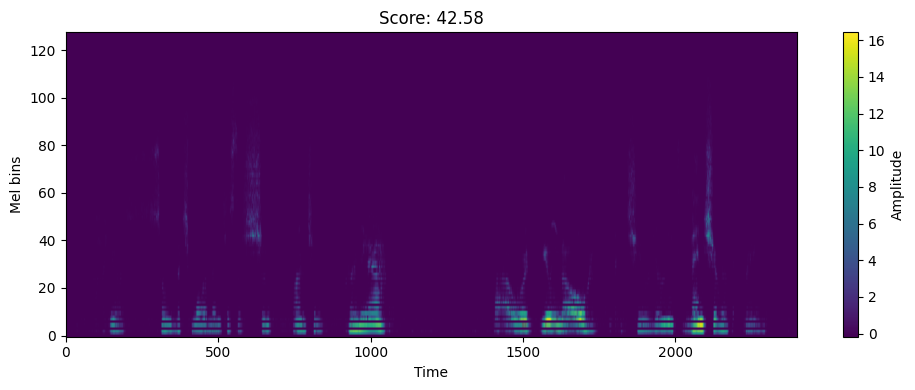

In [25]:
import matplotlib.pyplot as plt

# Mostra il primo spettrogramma del batch
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram[0].squeeze(0).numpy(), aspect='auto', origin='lower')
plt.title(f"Score: {score[0].item():.2f}")
plt.colorbar(label='Amplitude')
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.tight_layout()
plt.show()


# MODEL

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class AudioQualityCNN(nn.Module):
    def __init__(self):
        super(AudioQualityCNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # [16, 64, 1200]

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # [32, 32, 600]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))   # [64, 16, 300]
        )

        self.fc_block = nn.Sequential(
            nn.Flatten(),                      # [64 * 16 * 300] = 307200
            nn.Linear(64 * 16 * 300, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)                  # Output: qualità
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x.squeeze(1)  # Output shape: [batch_size]


# TRAIN

In [27]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioQualityCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()  # oppure nn.L1Loss() per MAE diretta
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


def train(model, train_loader, val_loader, epochs=20):
    best_val_loss = float('inf')
    patience = 3
    epochs_without_improvement = 0

    os.makedirs("model", exist_ok=True)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_mae = 0.0

        loop = tqdm(train_loader, total=len(train_loader))

        for batch in loop:
            inputs = batch['spectrogram'].to(device)
            targets = batch['score'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # MAE per batch
            batch_mae = torch.mean(torch.abs(outputs - targets)).item()
            running_mae += batch_mae * inputs.size(0)

            loop.set_description(f"\033[34mEpoch [{epoch+1}/{epochs}]\033[0m")
            loop.set_postfix(loss=loss.item(), mae=batch_mae)

        avg_train_loss = running_loss / len(train_loader.dataset)
        avg_train_mae = running_mae / len(train_loader.dataset)

        scheduler.step(avg_train_loss)

        tqdm.write(f"\033[34mEpoch [{epoch+1}/{epochs}]\033[0m, "
                   f"Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.2f}")

        #### VALIDATION ####
        model.eval()
        val_loss = 0.0
        val_mae = 0.0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['spectrogram'].to(device)
                targets = batch['score'].to(device)
                outputs = model(inputs)

                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

                batch_mae = torch.mean(torch.abs(outputs - targets)).item()
                val_mae += batch_mae * inputs.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_mae = val_mae / len(val_loader.dataset)

        tqdm.write(f"\033[32mValidation Loss: {avg_val_loss:.4f}, Validation MAE: {avg_val_mae:.2f}\033[0m")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "model/best_model.pth")
            epochs_without_improvement = 0
            tqdm.write(f"\033[32mModel saved!\033[0m")
        else:
            epochs_without_improvement += 1
            tqdm.write(f"\033[31mNo improvement ({epochs_without_improvement}/{patience})\033[0m")

        if epochs_without_improvement >= patience:
            tqdm.write(f"\033[31mEarly stopping triggered\033[0m")
            break


In [29]:
train(model, train_loader, val_loader, epochs=30)


Epoch [1/30]: 100%|██████████| 6/6 [00:18<00:00,  3.11s/it, loss=587, mae=19.2]


Epoch [1/30], Train Loss: 673.4465, Train MAE: 21.66
Validation Loss: 864.6388, Validation MAE: 26.59
Model saved!


Epoch [2/30]: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it, loss=1.02e+3, mae=27.9]


Epoch [2/30], Train Loss: 713.6727, Train MAE: 22.19
Validation Loss: 907.2527, Validation MAE: 26.66
No improvement (1/3)


Epoch [3/30]: 100%|██████████| 6/6 [00:18<00:00,  3.11s/it, loss=602, mae=20.6]


Epoch [3/30], Train Loss: 700.6142, Train MAE: 22.24
Validation Loss: 847.1121, Validation MAE: 25.48
Model saved!


Epoch [4/30]: 100%|██████████| 6/6 [00:18<00:00,  3.09s/it, loss=636, mae=22]  


Epoch [4/30], Train Loss: 666.6382, Train MAE: 21.42
Validation Loss: 841.0141, Validation MAE: 25.81
Model saved!


Epoch [5/30]: 100%|██████████| 6/6 [00:18<00:00,  3.11s/it, loss=577, mae=21.7]


Epoch [5/30], Train Loss: 655.6476, Train MAE: 21.16
Validation Loss: 862.5699, Validation MAE: 25.92
No improvement (1/3)


Epoch [6/30]: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it, loss=1.28e+3, mae=28.9]


Epoch [6/30], Train Loss: 677.8350, Train MAE: 21.50
Validation Loss: 922.6269, Validation MAE: 27.18
No improvement (2/3)


Epoch [7/30]: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it, loss=645, mae=22.9]


Epoch [7/30], Train Loss: 647.8408, Train MAE: 21.41
Validation Loss: 919.3894, Validation MAE: 26.68
No improvement (3/3)
Early stopping triggered
